# Fit Hologram parameters For AuxTel

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : March 1st 2021
- version 3

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is


plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# constants

- all transverse physical coordinates are in mm and relative to beam optical center (at CCD center)

In [5]:
# conversion in good inits
u_radtodeg=180.0/np.pi
u_degtorad=np.pi/180.
u_mtomm=1e3

- all constants are refered as $c\_$

In [6]:
c_F=18.0*1.2*u_mtomm # Auxtel Focla length # ou 13.7m

In [7]:
c_F

21599.999999999996

In [8]:
c_Z1=200. # mm, distance between hologram and source plane during holo recording
c_Z0=178. # mm, distance between hologram and CCD plane for observations 

In [9]:
c_d1=20.0 # mm, disntance between the sources during recording 

In [10]:
c_x1_0=7  # mm , x-coordinates of the hologram optical center in the CCD ref frame
c_y1_0=5 # mm , y-coordinate of the hologram optical center in the CCD ref frame

In [30]:
c_beta0=10 #degree , angle of rotation of hologram source axis wrt CCD  

# Functions

- $(X,Y)$ : coordinates in CCD frame with telecope optical center as the origin
- $(x,y)$ : coordinates in hologram frame with telecope optical center as the origin the same reference axis as the CCD
- $(x_1,y_1)$ : coordinates in hologram reference frame, with telecope optical center as the origin, such the two sources A $(x_1(A),y_1(A))$ and B $(x_1(B),y_1(B))$ have coordinates:
$$
x_1(A)= x_1 (0)-d_1/2 
$$
$$
y_1(A)= y_1(0)
$$
$$
x_1(B)= x_1 (0)+d_1/2 
$$
$$
y_1(B)= y_1(0)
$$

In [12]:
def XYtoxy(XY,Z):
    """
    XYtoxy(XY,Z): convert coordinates in CCD plane (R) to the CCD plane projected at hologram plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    The coordinates undergo an homothetie.
    
    
    
    input parameters
    - XY : numpy array of the 2-coordinates in CCD in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - xy : numpy array of the 2-coordinates in  in mm at hologram position
    """
    XY=np.array(XY)
    xy=(1-Z/c_F)*XY  #small contraction
    
    return xy  

In [13]:
def xytoXY(xy,Z):
    """
    xytoXY(xy,Z): convert coordinates in hologram plane to CCD plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    input parameters
    - xy : numpy array of the 2-coordinates in  in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - XY : numpy array of the 2-coordinates in CCD in mm
    
    """
    xy=np.array(xy)
    XY=1./(1-Z/c_F)*xy #small dilatation
    
    return XY  

In [14]:
def xytox1y1(xy,beta,x0,y0):
    """
    xytox1y1(xy,alpha): convert coordinates in hologram plane (same ref axis as CCD) with origin at O, the optical center
    of the telescope the instrinsic hologram frame with origin Oh, the optical center of the hologram.
    
    Both system are rotated by an angle beta such the Oh-x1 axis is parallel to sources A,B)
    
    input parameters
    - xy : numpy array of the 2-coordinates in hologram which ref axis are those of CCD and origin is O
    - beta : angle in degree
    
    - (x0,y0) : coordinate of hologram geometrical Oh (projected at hologram plane)
    
    output parameter 
    - x1y1 : mm, numpy array of the 2-coordinates in the intrinsic hologram frame
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    x=xy[0]-x0
    y=xy[1]-y0   
    x1y1=np.array([cos_beta*x+sin_beta*y,-sin_beta*x+cos_beta*y])
    
 

In [15]:
def xytox1y1_2D(x,y,beta,x0,y0):
    """
    
    2D version of function xytox1y1()
    
    convert coordinates in hologram plane (same ref axis as CCD) with origin at O, the optical center
    of the telescope the instrinsic hologram frame with origin Oh, the optical center of the hologram.
    
    Both system are rotated by an angle beta such the Oh-x1 axis is parallel to sources A,B)
     
    
    input parameters
    - x,y : 2D-numpy array of the 2-coordinates in hologram plane which ref axis are those of CCD and origin is O
    - alpha : angle in degree
    
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame projected at hologram plane
    Usually x0,y0 are 2D arrays representing 
    the various hypothesis on Oh position when computing a Chi2 
    
    output parameter 
    - x1,y1 : mm, 2D-numpy array of the 2-coordinates in the intrinsic hologram frame
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    x=x-x0
    y=y-y0
    
    x1=cos_beta*x+sin_beta*y
    y1=-sin_beta*x+cos_beta*y
    
    
    
    return x1,y1

In [16]:
def x1y1toxy(x1y1,beta,x0,y0):
    """
    x1y1toxy(x1y1,beta,x0,y0): convert coordinates in the intrinsic hologram frame R1h to the hologram frame Rh
    with same axis as CCD , both frame being rotated by a relative angle beta
    
    input parameters
    - x1y1 : mm, numpy array of the 2-coordinates in the intrinsic hologram frame  R1h
    - beta : angle in degree
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame but projected at hologram plane
    
    output parameter 
     - xy : numpy array of the 2-coordinates in hologram which ref axis are those of CCD mm
   
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    x1=x1y1[0]
    y1=x1y1[1]
    
    # note the coordinate are shifted wrt Oh point coordinates in CCD 
    xy=np.array([cos_beta*x1-sin_beta*y1+x0,sin_beta*x1+cos_beta*y1+y0])
    return xy

In [17]:
def x1y1toxy_2D(x1,y1,beta,x0,y0):
    """
    
    2D version of x1y1toxy(x1y1,beta,x0,y0):
    x1y1toxy_2D(x1,y1,alpha): convert coordinates in the intrinsic hologram frame  to the hologram frame 
    with same axis as CCD by an angle beta 
    
    input parameters
    - x1,y1 : mm, 2D numpy array of the 2-coordinates in the intrinsic hologram frame  
    - alpha : angle in degree
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame but projected at hologram plane
    
    output parameter 
     - x,y : 2D numpy array of the 2-coordinates in hologram which ref axis are those of CCD mm
   
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    
    x=cos_beta*x1-sin_beta*y1+x0
    y=sin_beta*x1+cos_beta*y1+y0
    return x,y

In [18]:
def dist1_to_source(xy,xy_s):
    """
    dist1_to_source(xy,xy_s) : distance between a point M(x,y) to a source S(x_S,y_s) at hologram recording phase
    
    The alpha hologram rotation angle is not important provided both point M and source S have the same reference axis
    
     input parameters
    - xy   : mm, 1D-numpy array of the 2-coordinates of point M in the  hologram frame  
    - xy_s : mm, 1D-numpy array of the 2-coordinates of the source in the  hologram frame  
    
    
    output parameter:
    return the 3d distance 
    
    """
    
    return np.sqrt(c_Z1**2+ (xy[0]-xy_s[0])**2+ (xy[1]-xy_s[1])**2)

In [19]:
def ddist1_to_source(x,y,x_s,y_s):
    """
    ddist1_to_source(xy,xy_s) : distance between a point M(x,y) to a source S(x_S,y_s) at hologram recording phase
    
    more efficient than dist1_to_source(xy,xy_s) because x,y are 2D numpy arrays.
    
    The alpha hologram rotation angle is not important provided both point M and source S have the same reference axis
    
     input parameters
    - x,y   : mm, 2D-numpy array of the 2-coordinates of point M in the  hologram frame  
    - x,y_s : mm, scalar the 2-coordinates of the source in the  hologram frame  
    
    
    output parameter:
    return the distance in 3D in a 2D numpy array
    
    Note : Either (x,y) are 2 2D-numpy array and (x_s,y_s) are 2 scalars 
           Or  (x,y) are 2 scalars and (x_s,y_s) are 2 2D-numpy arrays
    
    """
    
    return np.sqrt(c_Z1**2 + (x-x_s)**2+ (y-y_s)**2)

In [20]:
def d_phi(x1y1):
    """  
    d_phi(x1y1) : phase difference (distance difference at point(x1y1) )
    
    input parameters
    - x1y1   : mm, numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
         
    output parameter:
    return the angle d_alpha in degree
    
    """
    
    
    x1y1_A=np.array([-c_d1/2, 0]) # coordinate of source A
    x1y1_B=np.array([+c_d1/2, 0]) # coordinate of source B
    
    d1_A=dist1_to_source(x1y1,x1y1_A)  # distance to source A
    d1_B=dist1_to_source(x1y1,x1y1_B)  # distance to source B
    
    d_phi=d1_A-d1_B
   
    
    return d_phi

In [21]:
def dd_phi(x1,y1):
    """
    dd_alpha(x1,y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    more efficient than d_alpha(x1y1,x1y1_0) because x1,y1 are a 2D numpy array
    
    input parameters are 2D numpy array
    - x1,y1   : mm, 2D numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
     
    
    output parameter:
    return the angle d_alpha in degree in a 2D numpy array
    
    
    Notes :
     - Either (x1,y1) may be 2 2D-numpy arrays and x1_0,y1_0 two scalars : to get the d_alpha(x1,y1)
     - Or fix (x1,y1) as two scalars where the angle is measured and (x1_0,y1_0) are 2 2D numpy arrays
     for scanning in chi2 function the best position for parameters (x1_0,y1_0) 
    
    """
    
    
    x1_A=-c_d1/2 # coordinate of source A
    y1_A=0.        # coordinate of source A
    
    x1_B=c_d1/2 # coordinate of source B
    y1_B=0        # coordinate of source B
    
    dd1_A=ddist1_to_source(x1,y1,x1_A,y1_A)  # distance to source A in a 2D numpy array
    dd1_B=ddist1_to_source(x1,y1,x1_B,y1_B)  # distance to source B
    
    
    dd_phi=dd1_A-dd1_B
    
    return dd_phi # in a 2D numpy array

In [22]:
def d_alpha(x1y1):
    """
    d_alpha(x1y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    
    input parameters
    - x1y1   : mm, numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
    
     
    output parameter:
    return the angle d_alpha in degree
    
    """
    
    
    x1y1_A=np.array([-c_d1/2, 0]) # coordinate of source A
    x1y1_B=np.array([+c_d1/2, 0]) # coordinate of source B
    
    d1_A=dist1_to_source(x1y1,x1y1_A)  # distance to source A
    d1_B=dist1_to_source(x1y1,x1y1_B)  # distance to source B
    
    
    num_tan_dalpha= d1_B*(x1y1[1]-x1y1_A[1])-d1_A*(x1y1[1]-x1y1_B[1])
    den_tan_dalpha= d1_B*(x1y1[0]-x1y1_A[0])-d1_A*(x1y1[0]-x1y1_B[0])
    
    #tan_dalpha=- num_tan_dalpha/den_tan_dalpha
    tan_dalpha= num_tan_dalpha/den_tan_dalpha
    
    d_alpha=u_radtodeg*np.arctan(tan_dalpha)
    
    return d_alpha

In [23]:
def dd_alpha(x1,y1):
    """
    dd_alpha(x1,y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    more efficient than d_alpha(x1y1,x1y1_0) because x1,y1 are a 2D numpy array
    
    input parameters are 2D numpy array
    - x1,y1   : mm, 2D numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
     
    
    output parameter:
    return the angle d_alpha in degree in a 2D numpy array
    
    
    Notes :
     - Either (x1,y1) may be 2 2D-numpy arrays and x1_0,y1_0 two scalars : to get the d_alpha(x1,y1)
     - Or fix (x1,y1) as two scalars where the angle is measured and (x1_0,y1_0) are 2 2D numpy arrays
     for scanning in chi2 function the best position for parameters (x1_0,y1_0) 
    
    """
    
    
    x1_A=-c_d1/2 # coordinate of source A
    y1_A=0.        # coordinate of source A
    
    x1_B=c_d1/2 # coordinate of source B
    y1_B=0        # coordinate of source B
    
    dd1_A=ddist1_to_source(x1,y1,x1_A,y1_A)  # distance to source A in a 2D numpy array
    dd1_B=ddist1_to_source(x1,y1,x1_B,y1_B)  # distance to source B
    
    
    num_tan_dalpha= dd1_B*(y1-y1_A)-dd1_A*(y1-y1_B)
    den_tan_dalpha= dd1_B*(x1-x1_A)-dd1_A*(x1-x1_B)
    
    #tan_dalpha=- num_tan_dalpha/den_tan_dalpha
    tan_dalpha= num_tan_dalpha/den_tan_dalpha   
    #d_alpha=u_radtodeg*np.arctan(tan_dalpha)
    
    d_alpha=u_radtodeg*np.arctan2(num_tan_dalpha,den_tan_dalpha)
    
    return d_alpha # in a 2D numpy array

# Check formula

In [24]:
XMIN=-40
XMAX=40
YMIN=-40
YMAX=40
NPIX=1000

In [25]:
X = np.linspace(XMIN, XMAX, NPIX)
Y = np.linspace(YMIN, YMAX, NPIX)
XX, YY = np.meshgrid(X, Y, sparse=False)

### Constant relative phase or 3D- distance to sources 

In [26]:
Z_Phi_holo=dd_phi(XX,YY)

In [27]:
X_ccd = np.linspace(XMIN, XMAX, NPIX)
Y_ccd = np.linspace(YMIN, YMAX, NPIX)
XX_ccd, YY_ccd = np.meshgrid(X_ccd, Y_ccd, sparse=False)

# homothetie toward hologram plane
zoom=1.
xx_holo=XYtoxy(XX_ccd,c_Z0*zoom) 
yy_holo=XYtoxy(YY_ccd,c_Z0*zoom) 

# rotation from CCD orientation toward hologram 
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,c_beta0,c_x1_0,c_y1_0)
Z_Phi_ccd=dd_phi(xx1_holo,yy1_holo) # compute dispersion angle inside hologram frame

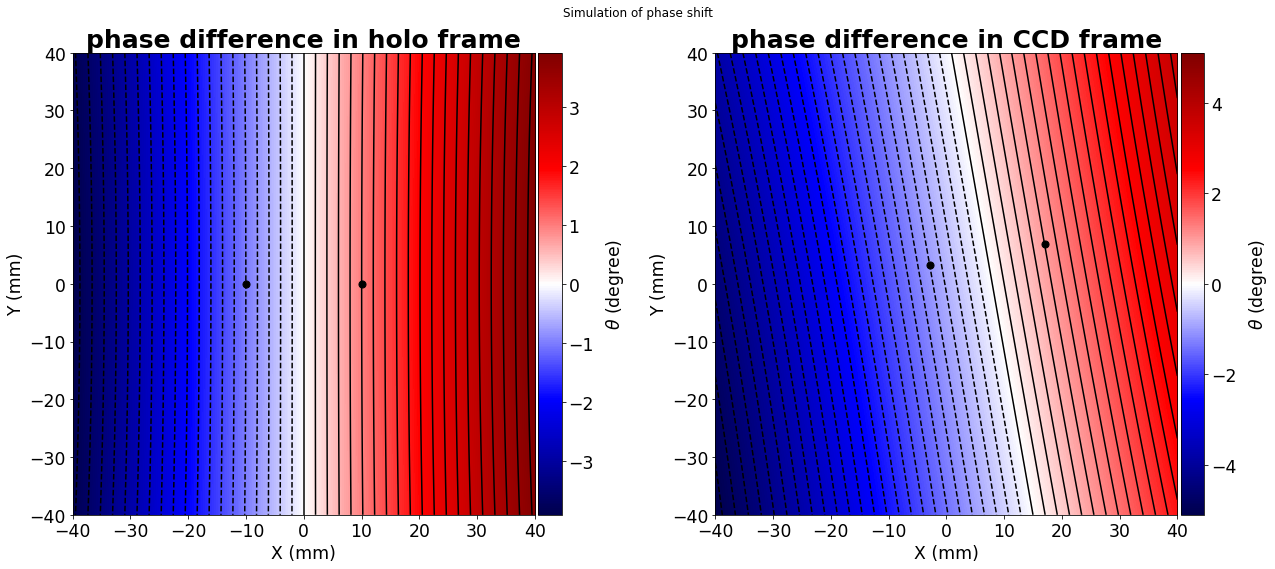

In [28]:
fig = plt.figure(figsize=(18,8))


# relative phase in hologram frame
ax1 = fig.add_subplot(121)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)


im1=ax1.imshow(Z_Phi_holo,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X,Y,Z_Phi_holo,levels=50,colors='k')
cbar1=fig.colorbar(im1,cax=cax1)

cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\theta$ (degree)', rotation=90)

xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])

ax1.scatter(xy1_A[0],xy1_A[1],marker="o",color="k",s=50)
ax1.scatter(xy1_B[0],xy1_B[1],marker="o",color="k",s=50)

ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("phase difference in holo frame",fontweight="bold",fontsize=25)


# relative phase difference in CCD frame when hologram is rotated by an angle beta
ax2 = fig.add_subplot(122)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
maxPhi=np.max(np.abs(Z_Phi_ccd))

im2=ax2.imshow(Z_Phi_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxPhi,vmax=maxPhi)
h2 = ax2.contour(X_ccd,Y_ccd,Z_Phi_ccd,levels=50,colors='k')
cbar2=fig.colorbar(im2,cax=cax2)

cbar2.ax.get_yaxis().labelpad = 10
cbar2.ax.set_ylabel('$\\theta$ (degree)', rotation=90)



xy_A = x1y1toxy(xy1_A,c_alpha0,c_x1_0,c_y1_0)
xy_B = x1y1toxy(xy1_B,c_alpha0,c_x1_0,c_y1_0)


XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax2.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=50)
ax2.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=50)


ax2.set_xlabel("X (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("phase difference in CCD frame",fontweight="bold",fontsize=25)

plt.suptitle("Simulation of phase shift")
plt.tight_layout()

### dispersion angle Alpha

In [ ]:
Z_Ang_holo=dd_alpha(XX,YY)

In [ ]:
X_ccd = np.linspace(XMIN, XMAX, NPIX)
Y_ccd = np.linspace(YMIN, YMAX, NPIX)
XX_ccd, YY_ccd = np.meshgrid(X_ccd, Y_ccd, sparse=False)

# homothecy
zoom=1.5
xx_holo=XYtoxy(XX_ccd,c_Z1*zoom) 
yy_holo=XYtoxy(YY_ccd,c_Z1*zoom) 

# rotation
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,c_alpha0,c_x1_0,c_y1_0)
Z_Ang_ccd=dd_alpha(xx1_holo,yy1_holo)

In [ ]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)


im1=ax1.imshow(Z_Ang_holo,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X,Y,Z_Ang_holo,levels=50,colors='k')
cbar1=fig.colorbar(im1,cax=cax1)

cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\theta$ (degree)', rotation=90)

xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])

ax1.scatter(xy1_A[0],xy1_A[1],marker="o",color="k",s=50)
ax1.scatter(xy1_B[0],xy1_B[1],marker="o",color="k",s=50)

ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("disp axis Angle in holo frame",fontweight="bold",fontsize=25)


ax2 = fig.add_subplot(122)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)

maxAng=np.max(np.abs(Z_Ang_ccd))
im2=ax2.imshow(Z_Ang_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxAng,vmax=maxAng)
h2 = ax2.contour(X_ccd,Y_ccd,Z_Ang_ccd,levels=50,colors='k')
cbar2=fig.colorbar(im2,cax=cax2)

cbar2.ax.get_yaxis().labelpad = 10
cbar2.ax.set_ylabel('$\\theta$ (degree)', rotation=90)



xy_A = x1y1toxy(xy1_A,c_alpha0,c_x1_0,c_y1_0)
xy_B = x1y1toxy(xy1_B,c_alpha0,c_x1_0,c_y1_0)


XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax2.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=50)
ax2.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=50)


ax2.set_xlabel("X (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("disp axis Angle in CCD frame",fontweight="bold",fontsize=25)


plt.tight_layout()

# Estimation of hologram parameters

## Random points

In [ ]:
NumberofPoints=50
Nxsim=np.random.randint(NPIX, size=(NumberofPoints))
Nysim=np.random.randint(NPIX, size=(NumberofPoints))
Xsim=X_ccd[Nxsim]
Ysim=Y_ccd[Nysim]

## Simulated Measurement

In [ ]:
sigma_alpha=0.01 # measurement error on angle in degree

In [ ]:
# group the data points
XYsim=np.array(list(zip(Xsim,Ysim)))

In [ ]:
# convert coordinates in hologram frame (same orientation as CCD)
xysim=XYtoxy(XYsim,c_Z1*zoom)

In [ ]:
# apply true rotation to have coordinates in intrisic hologram frame
x1y1sim=np.zeros(xysim.shape)
for idx in np.arange(NumberofPoints):
    x1y1sim[idx,:]=xytox1y1(xysim[idx],c_alpha0,c_x1_0,c_y1_0)

In [ ]:
# calculate d_alpha for the data (in intrinsic hologram ref frame) in degree
d_alpha=dd_alpha(x1y1sim[:,0],x1y1sim[:,1])

In [ ]:
# simulate measurement of angle in CCD frame
Zsim=c_alpha0+d_alpha+np.random.normal(loc=0,scale=sigma_alpha)

In [ ]:
Zerrsim=np.full(NumberofPoints,sigma_alpha)

## Plot simulated points

In [ ]:
fig = plt.figure(figsize=(8,8))

ax2 = fig.add_subplot(111)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)

maxAng=np.max(np.abs(Z_Ang_ccd))
im2=ax2.imshow(Z_Ang_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxAng,vmax=maxAng)
h2 = ax2.contour(X_ccd,Y_ccd,Z_Ang_ccd,levels=100,colors='k')
cbar2=fig.colorbar(im2,cax=cax2)

cbar2.ax.get_yaxis().labelpad = 10
cbar2.ax.set_ylabel('$\\theta$ (degree)', rotation=90)

xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])

xy_A = x1y1toxy(xy1_A,c_alpha0,c_x1_0,c_y1_0)
xy_B = x1y1toxy(xy1_B,c_alpha0,c_x1_0,c_y1_0)

XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax2.scatter(XY_A[0],XY_A[1],marker="o",color="g",s=100)
ax2.scatter(XY_B[0],XY_B[1],marker="o",color="g",s=100)

ax2.scatter(X[Nxsim],Y[Nysim],marker="o",color="k")

ax2.set_xlabel("X (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("Simulation in CCD frame",fontweight="bold",fontsize=25)



# Chi2 function

In [ ]:
def chi2func(Xdata,Ydata,Zdata,Zerrdata,X0,Y0,alpha,Z,Npar=2):
    """
    Total Chi2, do not divide by the number of data points 
    
    - input parameters
      - Xdata,Ydata,Zdata :three 1D-numpy array: Xdata,Ydata coordinates of order zero, Zdata angle measured
      - X0,Y0 2 2D numpy arrays of unknown parameters to fit (optical center of hologram in CCD frame)
      - alpha,Z other parameters
      - sig : experimental error on angle
      - Npar : number of parameter to use in degrees of freedom
      
    - ouput
     - 2D numpy array of chi2 representing the chi2
     
    """
    
   
    N=len(Xdata)
    chi2=0
 
    # loop on data
    for idx in np.arange(N):
        
        X=Xdata[idx] # scalar
        Y=Ydata[idx]
        
        XY=np.array([X,Y])
        
        # homothecie according the Z assumption
        xy=XYtoxy(XY,Z)
    
        # rotation according the alpha assumption
        x1y1=xytox1y1(xy,alpha,X0,Y0)
        
        d_alpha=dd_alpha(x1y1[0],x1y1[1])
        
        # angle in the model in CCD frame
        angle_mod=alpha+d_alpha
        
        #angle measured in CCD frame
        angle_mes=Zdata[idx]
    
        sig=Zerrdata[idx]
    
        if sig!=0:
            chi2+=(angle_mod-angle_mes)**2/sig**2
        
        
    return chi2 

# Quantiles

In [ ]:
from scipy.stats import chi2

In [ ]:
CL=np.array([0.683,0.9,0.95,0.99])
Qcolors=["r","m","orange","yellow"]

In [ ]:
NDF=2

In [ ]:
Q=chi2.ppf(CL,df=NDF)

In [ ]:
Q

In [ ]:
fig = plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)
ax.hist(Zsim,bins=50,facecolor="b");
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_title("distrib of holo angle")

## Calculation of chi2

In [ ]:
#def chi2(Xdata,Ydata,Zdata,X0,Y0,alpha,Z,sig,Npar=2)
#def chi2(Xdata,Ydata,Zdata,X0,Y0,alpha,Z,sig,Npar)
the_chi2=chi2func(Xsim,Ysim,Zsim,Zerrsim,XX_ccd,YY_ccd,c_alpha0,c_Z1*zoom,Npar=2)

## Plot

In [ ]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-1,1)) 

In [ ]:
fig = plt.figure(figsize=(20,10))


ax1 = fig.add_subplot(121)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

the_chi2min=the_chi2.min()
the_levels= the_chi2min + Q

im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
#h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)
cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("chi2",fontweight="bold",fontsize=25)
ax1.grid(color="w")



idx_y_chi2min,idx_x_chi2min=np.where(the_chi2==the_chi2min)

x_chi2min=X_ccd[idx_x_chi2min][0]
y_chi2min=Y_ccd[idx_y_chi2min][0]

ax2 = fig.add_subplot(122)
xmin=x_chi2min-5
xmax=x_chi2min+5
ymin=y_chi2min-5
ymax=y_chi2min+5

ibinx=np.where(np.logical_and(X_ccd>=xmin,X_ccd<=xmax))[0]
ibiny=np.where(np.logical_and(Y_ccd>=ymin,X_ccd<=ymax))[0]
chi2_cut=the_chi2[ibiny.min():ibiny.max(), ibinx.min():ibinx.max()]
X_cut=X[ibinx.min():ibinx.max()]
Y_cut=X[ibiny.min():ibiny.max()]


divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
im2=ax2.imshow(chi2_cut,origin="lower",cmap="jet",extent=(xmin,xmax,ymin,ymax))
h2 = ax2.contour(X_cut,Y_cut,chi2_cut,levels=100,colors='w')
#h2b = ax2.contour(X_cut,Y_cut,chi2_cut,levels=[2.30+chi2_cut.min()],colors='r',linewidths=2)
h2b = ax2.contour(X_cut,Y_cut,chi2_cut,levels=the_levels,colors=Qcolors,linewidths=2)
cbar2=fig.colorbar(im2,cax=cax2,format=cbformat)
cbar2.ax.get_yaxis().labelpad = 10
cbar2.ax.set_ylabel('$\\chi^2$', rotation=90)
#cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
#cbformat.set_powerlimits((-2,4))   
ax2.set_xlabel("X (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("chi2 cut",fontweight="bold",fontsize=25)
ax2.grid(color="w")

plt.tight_layout()
plt.show()

# Parameter Grid

In [ ]:
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [ ]:
Ncol=4
Nrow=4
Nalpha=Nrow*Ncol
alpha_range=5
alpha_min=c_alpha0-alpha_range
alpha_max=c_alpha0+alpha_range
alpha_step=(alpha_max-alpha_min)/Nalpha
alpha_values=np.linspace(alpha_min,alpha_max,Nalpha)

In [ ]:
fig = plt.figure(figsize=(16,16))
the_chi2min=np.zeros(Nalpha)
the_locchi2min = []
# loop on angle
for idx in np.arange(Nalpha):
    ax1=fig.add_subplot(Nrow,Ncol,idx+1)
    the_chi2=chi2func(Xsim,Ysim,Zsim,Zerrsim,XX_ccd,YY_ccd,alpha_values[idx],c_Z1*zoom,Npar=2)
    the_chi2min[idx]=the_chi2.min()  # value of chi2min
    the_levels= the_chi2min[idx] + Q
    the_locchi2min.append(np.where(the_chi2==the_chi2.min())) # location of chi2min 
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    
    
    im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
    h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
    #h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
    h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)
    cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
    cbar1.ax.get_yaxis().labelpad = 10
    cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    title="$\\alpha$ = {:3.2f}".format(alpha_values[idx])
    ax1.set_title(title,fontweight="bold")
    ax1.grid(color="w")
    
plt.suptitle("Simulation : hologram parameter search",y=1)
#plt.tight_layout()


In [ ]:
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [ ]:
the_chi2min = the_chi2min/NumberofPoints

In [ ]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(alpha_values,the_chi2min,'bo-')
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$\\chi^2(\\alpha)/NDF$")
ax.set_title("$simulation : \chi^2$ per degree of freedom vs holo angle $\\alpha$")

### Find where we have the chi2 min

In [ ]:
the_chi2min.min()

In [ ]:
idx_min=np.where(the_chi2min==the_chi2min.min())[0][0]
idx_min

In [ ]:
found_angle_1=alpha_values[idx_min]
found_angle_1

In [ ]:
idx_chi2min_y,idx_chi2min_x=the_locchi2min[idx_min]

In [ ]:
X_ccd[idx_chi2min_x][0]

In [ ]:
Y_ccd[idx_chi2min_y][0]

# With AuxTel data

In [ ]:
from IPython.display import Image
#Image(filename='figures/amas_ouvert.png') 

In [ ]:
#Image(filename='figures/AmasOuvert_holophilines.png')

## read excel file

In [ ]:
GOOGLE_COLAB = False

In [ ]:
if GOOGLE_COLAB:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

    filedata="orientations-holo_auxtel_v6.xlsx"
    df=pd.read_excel(filedata,index_col=None,header=42)

else:

    version="v7"
    if version=="v3":
        filedata="../data/orientations/orientations-holo_auxtel_v3.xlsx"
        df=pd.read_excel(filedata,index_col=None,header=17)
        df=df[df.index>24]
    elif version=="v5":
        filedata="../data/orientations/orientations-holo_auxtel_v5.xlsx"
        df=pd.read_excel(filedata,index_col=None,header=42)
    elif version=="v6":
        filedata="../data/orientations/orientations-holo_auxtel_v6.xlsx"
        df=pd.read_excel(filedata,index_col=None,header=42)    
    elif version=="v7":
        filedata="../data/orientations/orientations-holo_auxtel_v7.xlsx"
        df=pd.read_excel(filedata,index_col=None,header=42)    
    else:
        df=pd.read_excel(filedata,index_col=None,header=17)

In [ ]:
df

In [ ]:
filedata

In [ ]:
df.index

In [ ]:
df.columns

## Erreur expérimentale

In [ ]:
#sigma_alpha_exp=0.04 # error on angles
sigma_alpha_exp=0.16 # error on angles

### Show columns

In [ ]:
df.columns

### Extract good columns

In [ ]:
if version=="v6" or version == "v7":
    df=df[['X(mm)', 'Y(mm)','degré','dalpha']]
else:
    df=df[['X(mm)', 'Y(mm)','degré']]

In [ ]:
df.columns

### Describe

In [ ]:
df.describe()

## Extract data

In [ ]:
NumberofPointsData=len(df)

Xdata=df["X(mm)"].values
Ydata=df["Y(mm)"].values
alphadata=df["degré"].values
if version == "v6" or version == "v7" :
    alphaerrdata=df["dalpha"].values
else:
    alphaerrdata=np.full(NumberofPointsData,sigma_alpha_exp)

In [ ]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.hist(alphadata,bins=50,facecolor="b");
ax.set_xlabel('$\\alpha$ (deg)')

In [ ]:
slope_mag=1
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
for idx in np.arange(NumberofPointsData):
    x_i=Xdata[idx]
    y_i=Ydata[idx]
    slope=np.tan(alphadata[idx]*u_degtorad)
    
    slope*=slope_mag
    
    ax.scatter(x_i,y_i,marker="o",color="r")
    x_1=-20
    x_2=20
    y_1=(x_1-x_i)*slope+y_i
    y_2=(x_2-x_i)*slope+y_i
    ax.plot([x_1,x_2],[y_1,y_2])
    
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="data"
ax.set_title(title,fontweight="bold")
ax.grid(color="grey")
     

## Keep first hypothesis on rotation angle from data

- keep the average angle

In [ ]:
assummed_angle_0=df.mean()["degré"]
assummed_angle_0

## Parameter grid for parameter search

In [ ]:
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

### Step 1

#### prior region on angle search

In [ ]:
Ncol=5
Nrow=5
Nalpha=Nrow*Ncol
alpha_range=10
alpha_min=assummed_angle_0-alpha_range
alpha_max=assummed_angle_0+alpha_range
alpha_step=(alpha_max-alpha_min)/Nalpha
alpha_values=np.linspace(alpha_min,alpha_max,Nalpha)
zoom=1

#### Plot the grid for minimum seach

In [ ]:
fig = plt.figure(figsize=(16,16))
the_chi2min=np.zeros(Nalpha) # minimum value
the_locchi2min=[] # location of minimum
# loop on angle
for idx in np.arange(Nalpha):
    ax1=fig.add_subplot(Nrow,Ncol,idx+1)
    the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,alpha_values[idx],c_Z1*zoom,Npar=2)
    the_chi2min[idx]=the_chi2.min()    # the minimum of chi2
    the_levels= the_chi2min[idx] + Q
    the_locchi2min.append(np.where(the_chi2==the_chi2.min())) # location of chi2min 
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
    h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
    #h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
    h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)
    cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
    cbar1.ax.get_yaxis().labelpad = 10
    cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    title="$\\alpha$ = {:3.2f}".format(alpha_values[idx])
    ax1.set_title(title,fontweight="bold")
    ax1.grid(color="w")
    
plt.suptitle("AuxTel Data : hologram parameters search, step 1",y=1,fontsize=15)
    
#plt.tight_layout()


In [ ]:
the_chi2min=the_chi2min/NumberofPointsData

In [ ]:
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [ ]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(alpha_values,the_chi2min,'bo-')
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$\\chi^2(\\alpha)$")
ax.set_title("Auxtel data, step 1 : $\chi^2$ vs holo angle $\\alpha$")

In [ ]:
the_chi2min.min()

In [ ]:
idx_min=np.where(the_chi2min==the_chi2min.min())[0][0]

In [ ]:
found_angle_1=alpha_values[idx_min]
found_angle_1

In [ ]:
idx_chi2min_y,idx_chi2min_x=the_locchi2min[idx_min]

In [ ]:
X0_found_1=X_ccd[idx_chi2min_x][0]
X0_found_1

In [ ]:
Y0_found_1=Y_ccd[idx_chi2min_y][0]
Y0_found_1

### Step 1 : Calcul du chi2

In [ ]:
the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,found_angle_1,c_Z1*zoom,Npar=2)

#### Plot the result of step 1

In [ ]:
fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

the_chi2min=the_chi2.min()    # the minimum of chi2
the_levels= the_chi2min + Q
    
im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
#h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)

cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("chi2, step 1",fontweight="bold",fontsize=25)
ax1.grid(color="w")


#xy1_A=np.array([X0_found_1-c_d1/2,Y0_found_1])
#xy1_B=np.array([X0_found_1+c_d1/2,Y0_found_1])

#xy_A = x1y1toxy(xy1_A,c_alpha0)
#xy_B = x1y1toxy(xy1_B,c_alpha0)

#XY_A = xytoXY(xy_A,c_Z1*zoom)
#XY_B = xytoXY(xy_B,c_Z1*zoom)

ax1.scatter(X0_found_1,Y0_found_1,marker="o",color="y",s=100)
#ax1.scatter(XY_A[0],XY_A[1],marker="o",color="g",s=100)
#ax1.scatter(XY_B[0],XY_B[1],marker="o",color="g",s=100)

ax1.scatter(Xdata,Ydata,marker="o",color="gray")


In [ ]:
#Image(filename='figures/amas_ouvert.png') 

### Step 2

In [ ]:
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [ ]:
Ncol=5
Nrow=5
Nalpha=Nrow*Ncol
alpha_range=1
alpha_min=found_angle_1-alpha_range
alpha_max=found_angle_1+alpha_range
alpha_step=(alpha_max-alpha_min)/Nalpha
alpha_values=np.linspace(alpha_min,alpha_max,Nalpha)
zoom=1

In [ ]:
fig = plt.figure(figsize=(16,16))
the_chi2min=np.zeros(Nalpha)
the_locchi2min=[]

# loop on angle
for idx in np.arange(Nalpha):
    ax1=fig.add_subplot(Nrow,Ncol,idx+1)
    the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,alpha_values[idx],c_Z1*zoom,Npar=2)
    the_chi2min[idx]=the_chi2.min()
    the_levels= the_chi2min[idx] + Q
    
    the_locchi2min.append(np.where(the_chi2==the_chi2.min())) # location of chi2min 
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
    h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
    #h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
    h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)
    cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
    cbar1.ax.get_yaxis().labelpad = 10
    cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    title="$\\alpha$ = {:3.2f}".format(alpha_values[idx])
    ax1.set_title(title,fontweight="bold")
    ax1.grid(color="w")
    
plt.suptitle("Auxtel Data : hologram parameters search, step 2",y=1,fontsize=25)
#plt.tight_layout()


In [ ]:
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [ ]:
the_chi2min=the_chi2min/NumberofPointsData

In [ ]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(alpha_values,the_chi2min,'bo-')
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$\\chi^2(\\alpha)/NDF$")
ax.set_title("Auxtel data  step 2 : $\chi^2/NDF$ vs holo angle $\\alpha$")

In [ ]:
the_chi2min.min()

In [ ]:
idx_min=np.where(the_chi2min==the_chi2min.min())[0][0]

In [ ]:
found_angle_2=alpha_values[idx_min]
found_angle_2

In [ ]:
idx_chi2min_y,idx_chi2min_x=the_locchi2min[idx_min]

In [ ]:
X0_found_2=X_ccd[idx_chi2min_x][0]
X0_found_2

In [ ]:
Y0_found_2=Y_ccd[idx_chi2min_y][0]
Y0_found_2

### step 2 :  chi2 map

In [ ]:
the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,found_angle_2,c_Z1*zoom,Npar=2)

In [ ]:
fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

the_chi2min=the_chi2.min()    # the minimum of chi2
the_levels= the_chi2min + Q
    
im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
#h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)

cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("chi2, step 2",fontweight="bold",fontsize=25)
ax1.grid(color="w")


#xy1_A=np.array([X0_found_1-c_d1/2,Y0_found_1])
#xy1_B=np.array([X0_found_1+c_d1/2,Y0_found_1])

#xy_A = x1y1toxy(xy1_A,c_alpha0)
#xy_B = x1y1toxy(xy1_B,c_alpha0)

#XY_A = xytoXY(xy_A,c_Z1*zoom)
#XY_B = xytoXY(xy_B,c_Z1*zoom)

ax1.scatter(X0_found_1,Y0_found_1,marker="o",color="y",s=100)
#ax1.scatter(XY_A[0],XY_A[1],marker="o",color="g",s=100)
#ax1.scatter(XY_B[0],XY_B[1],marker="o",color="g",s=100)

ax1.scatter(Xdata,Ydata,marker="o",color="gray")


In [ ]:
# homothecy
zoom=1.
xx_holo=XYtoxy(XX_ccd,c_Z1*zoom) 
yy_holo=XYtoxy(YY_ccd,c_Z1*zoom) 

# rotation
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,found_angle_2,X0_found_2,Y0_found_2)
Z_Phi_ccd_2=dd_phi(xx1_holo,yy1_holo)

maxZ_Phi_2=np.max(np.abs(Z_Phi_ccd_2))

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
for idx in np.arange(NumberofPointsData):
    x_i=Xdata[idx]
    y_i=Ydata[idx]
    slope=np.tan(alphadata[idx]*u_degtorad)
    ax.scatter(x_i,y_i,marker="o",color="r")
    x_1=-20
    x_2=20
    y_1=(x_1-x_i)*slope+y_i
    y_2=(x_2-x_i)*slope+y_i
    ax.plot([x_1,x_2],[y_1,y_2],lw=3)
    
    
im=ax.imshow(Z_Phi_ccd_2,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),alpha=0.5,vmin=-maxZ_Phi_2,vmax=maxZ_Phi_2)
h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd_2,levels=50,colors='k')

xy_A = x1y1toxy(xy1_A,found_angle_2,X0_found_2,Y0_found_2)
xy_B = x1y1toxy(xy1_B,found_angle_2,X0_found_2,Y0_found_2)


XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=100)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=100)


    
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="fit data : alpha= {:3.2f} deg , (X0,Y0)= ({:3.2f},{:3.2f})".format(found_angle_2,X0_found_2,Y0_found_2)
ax.set_title(title,fontweight="bold")
ax.grid(color="w")
    

### Step 3

In [ ]:
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [ ]:
Ncol=5
Nrow=5
Nalpha=Nrow*Ncol
alpha_range=0.2
alpha_min=found_angle_2-alpha_range
alpha_max=found_angle_2+alpha_range
alpha_step=(alpha_max-alpha_min)/Nalpha
alpha_values=np.linspace(alpha_min,alpha_max,Nalpha)
zoom=1

In [ ]:
fig = plt.figure(figsize=(16,16))
the_chi2min=np.zeros(Nalpha)
the_locchi2min=[]

# loop on angle
for idx in np.arange(Nalpha):
    ax1=fig.add_subplot(Nrow,Ncol,idx+1)
    the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,alpha_values[idx],c_Z1*zoom,Npar=2)
    the_chi2min[idx]=the_chi2.min()
    the_levels= the_chi2min[idx] + Q
    
    the_locchi2min.append(np.where(the_chi2==the_chi2.min())) # location of chi2min 
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
    h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
    #h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
    h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)
    cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
    cbar1.ax.get_yaxis().labelpad = 10
    cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    title="$\\alpha$ = {:3.2f}".format(alpha_values[idx])
    ax1.set_title(title,fontweight="bold")
    ax1.grid(color="w")
    
plt.suptitle("Auxtel Data : hologram parameters search, step 3",y=1)
#plt.tight_layout()


In [ ]:
the_chi2min=the_chi2min/NumberofPointsData

In [ ]:
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [ ]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(alpha_values,the_chi2min,'bo-')
ax.set_xlabel("$\\alpha$ (deg)")
ax.set_ylabel("$\\chi^2(\\alpha)$")
ax.set_title("AuxTel data step 3 : $\chi^2$ vs holo angle $\\alpha$")

In [ ]:
the_chi2min.min()

In [ ]:
idx_min=np.where(the_chi2min==the_chi2min.min())[0][0]

In [ ]:
found_angle_3=alpha_values[idx_min]
found_angle_3

In [ ]:
idx_chi2min_y,idx_chi2min_x=the_locchi2min[idx_min]

In [ ]:
X0_found_3=X_ccd[idx_chi2min_x][0]
X0_found_3

In [ ]:
Y0_found_3=Y_ccd[idx_chi2min_y][0]
Y0_found_3

### step 3 : chi2 map

In [ ]:
the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,found_angle_3,c_Z1*zoom,Npar=2)

In [ ]:
fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

the_chi2min=the_chi2.min()    # the minimum of chi2
the_levels= the_chi2min + Q
    
im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
#h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)

cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("chi2, step 3",fontweight="bold",fontsize=25)
ax1.grid(color="w")


#xy1_A=np.array([X0_found_1-c_d1/2,Y0_found_1])
#xy1_B=np.array([X0_found_1+c_d1/2,Y0_found_1])

#xy_A = x1y1toxy(xy1_A,c_alpha0)
#xy_B = x1y1toxy(xy1_B,c_alpha0)

#XY_A = xytoXY(xy_A,c_Z1*zoom)
#XY_B = xytoXY(xy_B,c_Z1*zoom)

ax1.scatter(X0_found_1,Y0_found_1,marker="o",color="y",s=100)
#ax1.scatter(XY_A[0],XY_A[1],marker="o",color="g",s=100)
#ax1.scatter(XY_B[0],XY_B[1],marker="o",color="g",s=100)

ax1.scatter(Xdata,Ydata,marker="o",color="gray")


In [ ]:
# homothecy
zoom=1.
xx_holo=XYtoxy(XX_ccd,c_Z1*zoom) 
yy_holo=XYtoxy(YY_ccd,c_Z1*zoom) 

# rotation
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,found_angle_3,X0_found_3,Y0_found_3)
Z_Phi_ccd_3=dd_phi(xx1_holo,yy1_holo)

maxZ_Phi_3=np.max(np.abs(Z_Phi_ccd_3))

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
for idx in np.arange(NumberofPointsData):
    x_i=Xdata[idx]
    y_i=Ydata[idx]
    slope=np.tan(alphadata[idx]*u_degtorad)
    ax.scatter(x_i,y_i,marker="o",color="r")
    x_1=-20
    x_2=20
    y_1=(x_1-x_i)*slope+y_i
    y_2=(x_2-x_i)*slope+y_i
    ax.plot([x_1,x_2],[y_1,y_2],lw=3)
    
    
im=ax.imshow(Z_Phi_ccd_3,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),alpha=0.5,vmin=-maxZ_Phi_3,vmax=maxZ_Phi_3)
h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd_3,levels=50,colors='k')

xy_A = x1y1toxy(xy1_A,found_angle_3,X0_found_3,Y0_found_3)
xy_B = x1y1toxy(xy1_B,found_angle_3,X0_found_3,Y0_found_3)


XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=100)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=100)


    
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="fit data step 3 : alpha= {:3.2f} deg , (X0,Y0)= ({:3.2f},{:3.2f})".format(found_angle_3,X0_found_3,Y0_found_3)
ax.set_title(title,fontweight="bold")
ax.grid(color="w")
    

# Final Fit with iMinuit

https://nbviewer.jupyter.org/github/scikit-hep/iminuit/blob/master/tutorial/basic_tutorial.ipynb

In [ ]:
if GOOGLE_COLAB:
    !pip install iminuit

In [ ]:
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

In [ ]:
def chi2_angle(X0,Y0,alpha0):
    """
    - input x,y : model X0,Y0 in  CCD frame
    - alpha     : finite angle
    
    """
    
    N=len(Xdata)
    chi2=0
 
    # loop on data
    for idx in np.arange(N):
               
        X=Xdata[idx] # scalar
        Y=Ydata[idx]
        
        XY=np.array([X,Y])
        
        # homothecie according the Z assumption
        xy=XYtoxy(XY,c_Z0)
    
        # rotation according the alpha assumption
        x1y1=xytox1y1(xy,alpha0,X0,Y0)
        
        d_alpha=dd_alpha(x1y1[0],x1y1[1])
        
        
        # angle in the model
        angle_mod=alpha0+d_alpha
        
        #angle measured
        angle_mes=alphadata[idx]
    
        sig=alphaerrdata[idx]
        
        if sig>0:
            chi2+=(angle_mod-angle_mes)**2/sig**2
        
    return chi2

In [ ]:
X0_found_3

In [ ]:
Y0_found_3

In [ ]:
found_angle_3

In [ ]:
#chi2_angle.errordef=Minuit.LEAST_SQUARES  # == 1

In [ ]:
X0_th=-7.0
Y0_th=+2.5
alpha_th=0

In [ ]:
#m = Minuit(chi2_angle, X0=X0_found_3, Y0=Y0_found_3, alpha0=found_angle_3)  # starting values
m = Minuit(chi2_angle, X0=X0_th, Y0=Y0_th, alpha0=alpha_th)  # starting values

In [ ]:
m.errordef=1

In [ ]:
#m.limits = [(-20, 20), (-20, 10),(alpha_min,alpha_max)]

In [ ]:
m.migrad()  # finds minimum of least_squares function

In [ ]:
m.hesse()   # accurately computes uncertainties

In [ ]:
m.params

In [ ]:
m.covariance

In [ ]:
plt.figure(figsize=(5,5))
m.draw_mncontour("X0", "Y0")
plt.grid()

In [ ]:
plt.figure(figsize=(6,5))
m.draw_mnprofile("X0");

In [ ]:
plt.figure(figsize=(6,5))
m.draw_mnprofile("Y0");

In [ ]:
plt.figure(figsize=(6,5))
m.draw_mnprofile("alpha0");

In [ ]:
m.fval / (len(Xdata) - m.nfit)  # reduced chi2

In [ ]:
found_angle_minuit=m.params[2].value
X0_found_minuit=m.params[0].value
Y0_found_minuit=m.params[1].value

In [ ]:
the_chi2=chi2func(Xdata,Ydata,alphadata,alphaerrdata,XX_ccd,YY_ccd,found_angle_minuit,c_Z1*zoom,Npar=2)

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

the_chi2min=the_chi2.min()    # the minimum of chi2
the_levels= the_chi2min + Q
    
im1=ax1.imshow(the_chi2,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX))
h1 = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=100,colors='w')
#h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[2.30+the_chi2.min()],colors='r',linewidths=2)
h1b = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=the_levels,colors=Qcolors,linewidths=2)

cs = ax1.contour(X_ccd,Y_ccd,the_chi2,levels=[the_levels[0]],colors=Qcolors[0],linewidths=2)

p = cs.collections[0].get_paths()[0]
v = p.vertices
xcont = v[:,0]
ycont = v[:,1]


cbar1=fig.colorbar(im1,cax=cax1,format=cbformat)
cbar1.ax.get_yaxis().labelpad = 10
cbar1.ax.set_ylabel('$\\chi^2$', rotation=90)
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("chi2, step 3",fontweight="bold",fontsize=25)
ax1.grid(color="w")


#xy1_A=np.array([X0_found_1-c_d1/2,Y0_found_1])
#xy1_B=np.array([X0_found_1+c_d1/2,Y0_found_1])

#xy_A = x1y1toxy(xy1_A,c_alpha0)
#xy_B = x1y1toxy(xy1_B,c_alpha0)

#XY_A = xytoXY(xy_A,c_Z1*zoom)
#XY_B = xytoXY(xy_B,c_Z1*zoom)

ax1.scatter(X0_found_1,Y0_found_1,marker="o",color="y",s=100)
#ax1.scatter(XY_A[0],XY_A[1],marker="o",color="g",s=100)
#ax1.scatter(XY_B[0],XY_B[1],marker="o",color="g",s=100)

ax1.scatter(Xdata,Ydata,marker="o",color="gray")

ax1.set_title("Minuit result : $\chi2$ minimisation")


In [ ]:
# homothecy
zoom=1.
xx_holo=XYtoxy(XX_ccd,c_Z1*zoom) 
yy_holo=XYtoxy(YY_ccd,c_Z1*zoom) 

# rotation
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,found_angle_minuit,X0_found_minuit,Y0_found_minuit)
Z_Phi_ccd_minuit=dd_phi(xx1_holo,yy1_holo)

maxZ_Phi_minuit=np.max(np.abs(Z_Phi_ccd_minuit))

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
for idx in np.arange(NumberofPointsData):
    x_i=Xdata[idx]
    y_i=Ydata[idx]
    slope=np.tan(alphadata[idx]*u_degtorad)
    ax.scatter(x_i,y_i,marker="o",color="g")
    x_1=-20
    x_2=20
    y_1=(x_1-x_i)*slope+y_i
    y_2=(x_2-x_i)*slope+y_i
    ax.plot([x_1,x_2],[y_1,y_2],color="g",lw=1)
    
    
#im=ax.imshow(Z_Phi_ccd_3,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),alpha=0.5,vmin=-maxZ_Phi_minuit,vmax=maxZ_Phi_minuit)
h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd_minuit,levels=50,colors='orange',linewidth=6)

xy_A = x1y1toxy(xy1_A,found_angle_minuit,X0_found_minuit,Y0_found_minuit)
xy_B = x1y1toxy(xy1_B,found_angle_minuit,X0_found_minuit,Y0_found_minuit)


XY_A = xytoXY(xy_A,c_Z1*zoom)
XY_B = xytoXY(xy_B,c_Z1*zoom)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=100)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=100)

ax.scatter(X0_found_minuit,Y0_found_minuit,marker="+",color="b",s=5000,lw=2)

# center contour line
ax.plot(xcont,ycont,'r-')

# CCD border
ax.plot([-20,-20],[-20,20],color="grey",lw=5)
ax.plot([20,20],[-20,20],color="grey",lw=5)
ax.plot([-20,20],[-20,-20],color="grey",lw=5)
ax.plot([-20,20],[20,20],color="grey",lw=5)
    
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="Final fit with Minuit  : alpha= {:3.2f} deg , (X0,Y0)= ({:3.2f},{:3.2f})".format(found_angle_minuit,X0_found_minuit,Y0_found_minuit)
ax.set_title(title,fontweight="bold")
ax.grid(color="w")
    